<center> <h1> Vast Mini Challenge 1 </h1> </center>

## Context and objectives

This notebook contains our full analysis regarding the Vast Mini Challenge 1. Our goal is to investigate the data provided for the challenge and to either support or refute the Kasios claim that the Pipits are actually thriving across the Boonsong Lekagul Wildlife Preserve.
   
We were provided two types of information to lead our investigation: Information relative to the bird locations on the preserve and sound recordings for each different bird.  

We will Proceed in three steps: First, we wil analyse the data regarding the bird locations and go with a geographic approach to determine the thrutfulness of Kasios statement regarding the birds return.Then in a second phase, we will take a closer look at the sound recordings of the birds singing to try and identify the bird species in the recording provided by kasios. Last, we will implement a classification algorithm to reach a final conclusion.

# Part One: Analysing the geographic data 

## Displaying the Map

We will start our analysis by studying the collection of bird locations from the Preserve provided by the Mistford College. This collection regroups over 2000 samples of bird locations as well as other information for a variety of bird species living in the preserve.

In [29]:
#Importing the necessary librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
from scipy import misc
import imageio

 First, let's display the available map of the Lekagul Preserve:

/home/dounia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


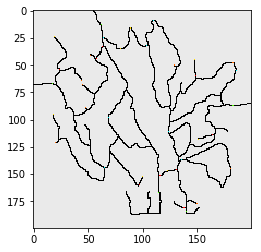

In [30]:
# We apload the image from the .bmp file provided for the challenge
path    = './'
image   = misc.imread(os.path.join(path,'map.bmp'))
imgplot = plt.imshow(image)
plt.show()

We notice that the original map is quite small and is of a low quality. We will try to resize it and switch the grey background into a white one in order to have more contrast between the map lines and the background.

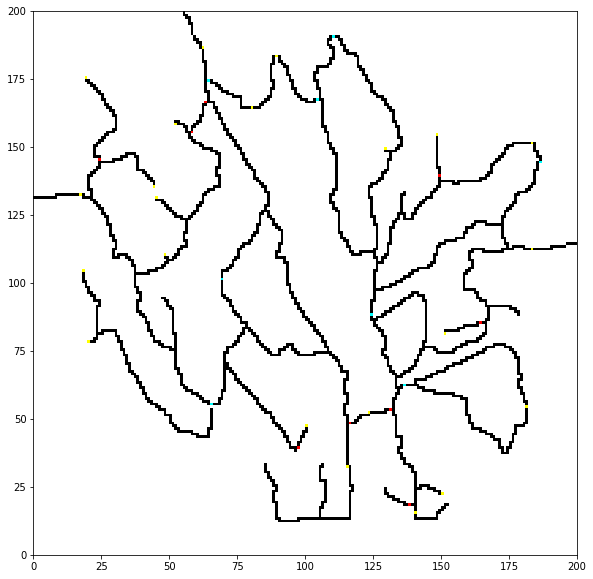

In [31]:
#switching the background to white 

def image_process(image):
    for i in range(200):
        for j in range(200):
            for l in range(3):
                if image[i][j][l] != 0 :
                    image[i][j][l] = 255
    return image
#Applying the transformation

image = image_process(image)

#Choose bigger figure size 

plt.figure(figsize=(20,10))
plt.grid(False)

#Displaying the new image 
imgplot = plt.imshow(image, extent= [0,200,0,200])
plt.show()

Resizing the original image resulted in a poor quality of for the outline of the map. 
We can try to use external tools to enhance the map by smoothing out the pixels and have a more even outline for the map.

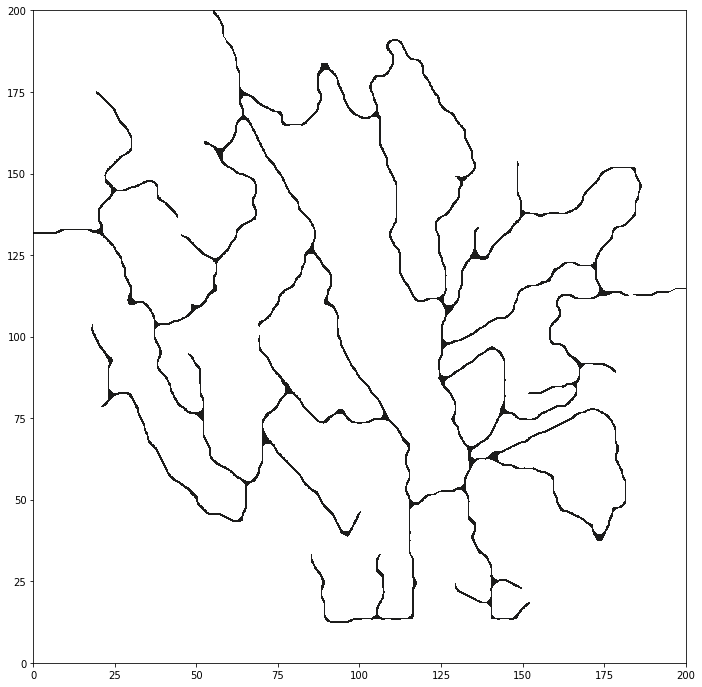

In [32]:
#Uploading an enhanced map to use 
path    = './'
image_1   = imageio.imread(os.path.join(path,'map_2.png'))

plt.figure(figsize=(24,12))
plt.grid(False)

#Displaying the new image 
imgplot = plt.imshow(image_1, extent= [0,200,0,200])
plt.show()

This version of the map seems more appropriate to be used further in this notebook.

## Exploring the Data

Now, let's upload the "AllBirdsv4.csv" file and take a look at the data 

In [33]:
#We read the Csv and define Data tables keeping only the bird name and its coordianates 
df = pd.read_csv('./AllBirdsv4.csv')
df_useful = df[['English_name','X','Y']]

#We add a preprocessing module to make sure all values are usable

def clean_int(x):
    try:
        return int(x)
    except :
        pass
    
df_useful['X']= df_useful['X'].apply(lambda x : clean_int(x))
df_useful['Y']= df_useful['Y'].apply(lambda x : clean_int(x))

#We draw a random sample 

df_useful.sample(10)

/home/dounia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dounia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


English_name    X    Y
1517      Purple Tooting Tout   81   52
1659               Queenscoat   43  108
49    Rose-crested Blue Pipit  125  121
308                  Bombadil   72  154
48    Rose-crested Blue Pipit  142  164
1769               Queenscoat   55  149
1496      Purple Tooting Tout  102   61
1269       Orange Pine Plover   63   44
1177       Orange Pine Plover   63   30
966         Lesser Birchbeere  121   72

In [34]:
# Number of elements in the file
df_useful.count()

English_name    2078
X               2078
Y               2078
dtype: int64

We notice that there are too many samples to print all of them individually on the same map. So we devised the following strategy:

- We will use the 2D map as a background for our plots
- We will represent every bird species with a different color as we are dealing with different categories
- Instead of plotting every bird coordinates as a dot (or with an 'o' Marker ) on the map, we will plot clusters of birds that we will compute using a clustering algorithm. The size of the ( 'o' Marker ) representing a cluster will be proportionnate to the population of birds of that cluster. The coordinates of the cluster will be computed based on the different coordinates.


## Clustering

In [35]:
#importing the necessary librairies 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
#Applying clustering algorithm with n clusters 

def process_cluster(df, n_clusters):
    """
    Takes a df with columns : English_name, X, Y, and n_clusters, representing the number of clusters to be used. 
    returns  : dataframe with bird type , its clusters, the cluster coordinates, and the number of birds per clusters
    """
    Empty_data = pd.DataFrame(columns= ['X', 'Y', 'cluster', 'number', 'English_name'])
    kmeans = KMeans(n_clusters= n_clusters)  #initialize the number of clusters
    output_array = []
    labels       = set(df['English_name'])  #representing the birds names 
    for label in labels : 
        df_loc   = df[df['English_name'] == label][['X','Y']]    #Takes the part of the dataframe corresponding to the bird
        X        = np.array(df_loc[['X','Y']])
        kmeans.fit(X)
        centroids                 = pd.DataFrame(kmeans.cluster_centers_, columns = ['X','Y'])
        centroids['cluster']      = np.arange(n_clusters)
        numbers                   = kmeans.predict(X)
        unique, counts            = np.unique(numbers, return_counts=True)
        occurences                = dict(zip(unique, counts))
        centroids['number']       = centroids['cluster'].apply(lambda x : occurences[x])
        centroids['English_name'] = label
        centroids = pd.DataFrame( centroids , columns= ['X', 'Y', 'cluster', 'number', 'English_name'])
        Empty_data= Empty_data.append(centroids)
        
    
    return Empty_data.reset_index().drop(['index'], axis = 1)

In [37]:
#Example of applying the clustering function :
#We cluster each bird category into 5 clusters for example

process = process_cluster( df_useful , 5 )
process.head(10)

X           Y cluster number                English_name
0   68.500000   45.000000       0     22         Purple Tooting Tout
1  124.333333   75.500000       1     18         Purple Tooting Tout
2   54.739130   99.043478       2     23         Purple Tooting Tout
3  145.000000  112.000000       3      6         Purple Tooting Tout
4   55.250000  158.250000       4      4         Purple Tooting Tout
5   57.303030   68.151515       0     33  Green-tipped Scarlet Pipit
6   79.500000  137.111111       1     18  Green-tipped Scarlet Pipit
7  137.888889   38.333333       2      9  Green-tipped Scarlet Pipit
8   29.300000  140.700000       3     20  Green-tipped Scarlet Pipit
9  142.750000  146.625000       4      8  Green-tipped Scarlet Pipit

In [38]:
#We map each type of bird to a color. We use 15 colors from the "Tableau 20"

def color_map(process):
    
    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)  
        
    #We do the mapping 
    process['color'] = process['English_name'].copy()
    labels = list(set(process['color']))
    for k in range(len(labels)) : 
        process.loc[process['color'] == labels[k] , 'color' ] = process.loc[process['color'] == labels[k] , 'color' ].apply(lambda x : tableau20[k] )
        
        
    return process 
    

In [39]:
process= color_map(process)
process.head(10)

X           Y cluster number                English_name  \
0   68.500000   45.000000       0     22         Purple Tooting Tout   
1  124.333333   75.500000       1     18         Purple Tooting Tout   
2   54.739130   99.043478       2     23         Purple Tooting Tout   
3  145.000000  112.000000       3      6         Purple Tooting Tout   
4   55.250000  158.250000       4      4         Purple Tooting Tout   
5   57.303030   68.151515       0     33  Green-tipped Scarlet Pipit   
6   79.500000  137.111111       1     18  Green-tipped Scarlet Pipit   
7  137.888889   38.333333       2      9  Green-tipped Scarlet Pipit   
8   29.300000  140.700000       3     20  Green-tipped Scarlet Pipit   
9  142.750000  146.625000       4      8  Green-tipped Scarlet Pipit   

                                               color  
0  (0.12156862745098039, 0.4666666666666667, 0.70...  
1  (0.12156862745098039, 0.4666666666666667, 0.70...  
2  (0.12156862745098039, 0.4666666666666667, 0.70...  
3  (0.12156862745098039, 0.4666666666666667, 0.70...  
4  (0.12156862745098039, 0.4666666666666667, 0.70...  
5  (0.6823529411764706, 0.7803921568627451, 0.909...  
6  (0.6823529411764706, 0.7803921568627451, 0.909...  
7  (0.6823529411764706, 0.7803921568627451, 0.909...  
8  (0.6823529411764706, 0.7803921568627451, 0.909...  
9  (0.6823529411764706, 0.7803921568627451, 0.909...

Now we have the RGB color for each bird type. We can plot the figure for different number of clusters and choose the best representation.

In [40]:
def plot_map(image , process):

    plt.figure(figsize=(24,12))

    labels = list(set(process['English_name']))
    

    for k in range(process.shape[0]) : 
        df_loc = process.iloc[k , :]
        plt.scatter(df_loc['X'], df_loc['Y'], s= df_loc['number']*10, color=df_loc['color'],alpha = 1) 
    
    for area in [16, 20, 35]:
        plt.scatter([], [], c='k', alpha=0.3, s=area*13,
                  label=str(area)  )
    plt.scatter([],[], color='white', alpha=1, s=40, label = ' \n   Type of birds')
    legend1= plt.legend(loc='best', scatterpoints=1, frameon=False, labelspacing=1, title='')

    df_loc_col = process['color'].unique()

    
    for k in range(len(labels)):
        df_loc = process.iloc[k , :]
        plt.scatter([], [], color=df_loc_col[k], alpha=1, s=80,
                   label=str(labels[k]) )
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, frameon=False, labelspacing=1, title='Number of birds')    
    
    
    plt.title('Birds distribution');


    extent= (0,200,0,200)

    imgplot = plt.imshow(image, extent= [0,200,0,200])



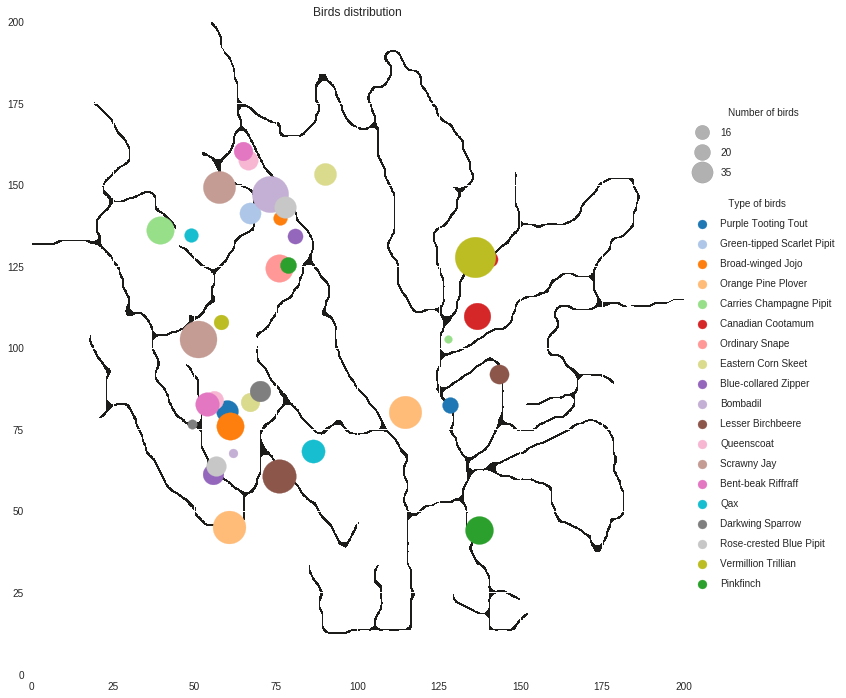

In [41]:
# let's try for different numbers of clusters 
# with n_cluster = 2 
process = color_map( process_cluster( df_useful , 2 ) )
plot_map(image_1 , process)

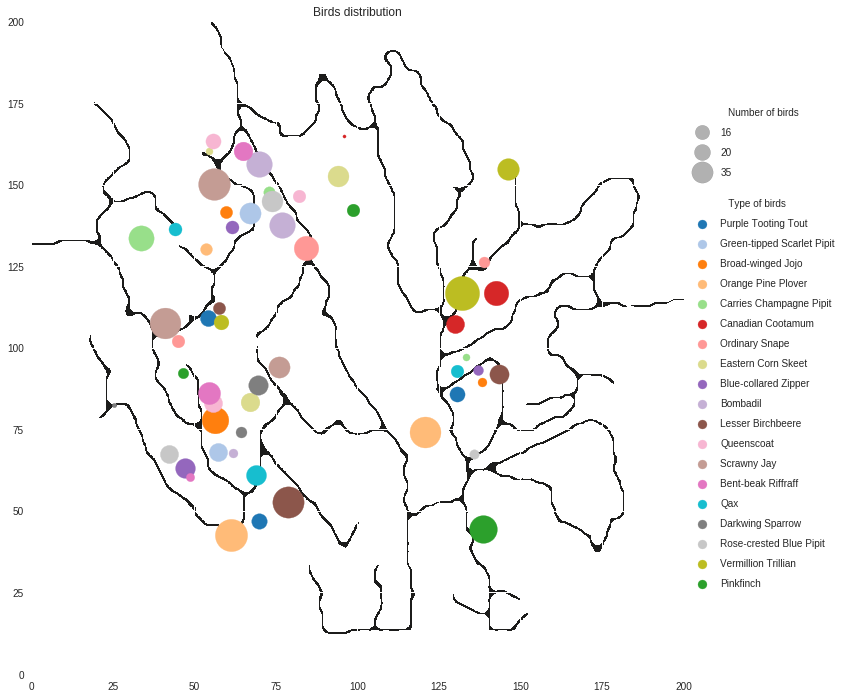

In [42]:
# let's try for different numbers of clusters 
# with n_cluster = 3 
process = color_map( process_cluster( df_useful , 3 ) )
plot_map(image_1 , process)

Now let's add the 15 positions provided by Kasios and display the final map 

In [43]:
#Adding the 15 positions from the kasios file
df_2 = pd.read_csv('./Test Birds Location.csv')
df_useful_2 = df_2.copy()

In [46]:
# adding the plot of the new positions to original plot
def plot_map_complete(image , process , df_useful_2):

    plt.figure(figsize=(24,12))

    labels = list(set(process['English_name']))
    

    for k in range(process.shape[0]) : 
        df_loc = process.iloc[k , :]
        plt.scatter(df_loc['X'], df_loc['Y'], s= df_loc['number']*10, color=df_loc['color'],alpha = 1) 
    
    for area in [16, 20, 35]:
        plt.scatter([], [], c='k', alpha=0.3, s=area*13,
                  label=str(area)  )
    plt.scatter([],[], color='white', alpha=1, s=40, label = ' \n   Type of birds')
    legend1= plt.legend(loc='best', scatterpoints=1, frameon=False, labelspacing=1, title='')

    df_loc_col = process['color'].unique()

    plt.scatter(df_useful_2[' X'], df_useful_2[' Y'], s= 200, color='black', marker = "X" , alpha = 0.9 , label ='kasios birds')
    
    for k in range(len(labels)):
        df_loc = process.iloc[k , :]
        plt.scatter([], [], color=df_loc_col[k], alpha=1, s=80,
                   label=str(labels[k]) )
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, frameon=False, labelspacing=1, title='Number of birds')    
    
    
    plt.title('Birds distribution');


    extent= (0,200,0,200)

    imgplot = plt.imshow(image, extent= [0,200,0,200])



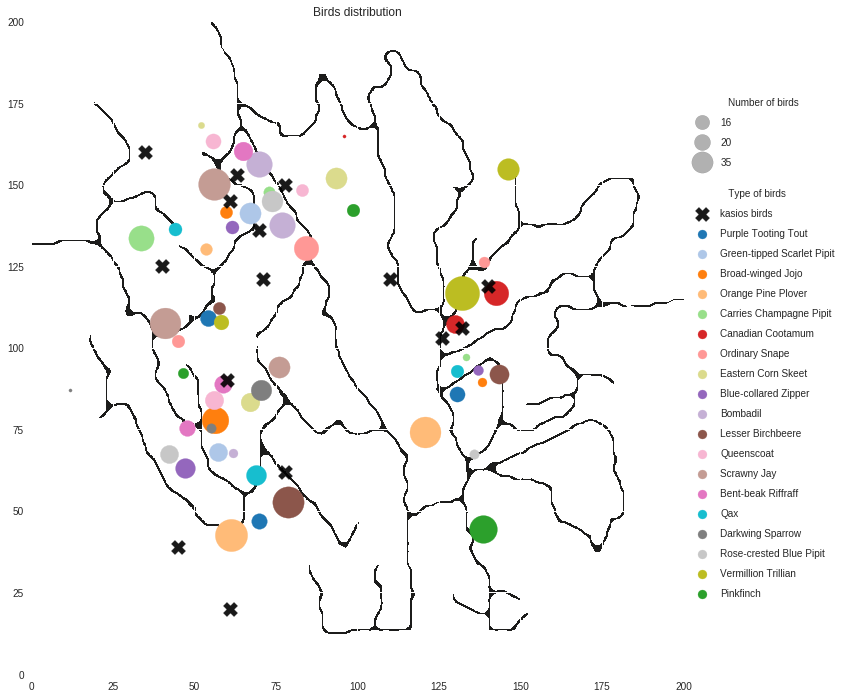

In [47]:
#The final visualisation is the following
process = color_map( process_cluster( df_useful ,3) )
plot_map_complete(image_1 , process , df_useful_2)

## Analysing the results

Now that we were able to develop a clustering algorithm on the bird species let's analyse our results with regards to our final goal: decide if the bird species from the Kasios test file are indeed Rose crested Blue pipits or not.

From the clustering above, we notice that each specie of birds seem to live in particular spots on the map, meaning that each bird specie has some natural habitats in the preserve that they usually live in.
let's take a closer look at some of the birds species:

Taking three different kinds of species, when we try to create two clusters for each specie:

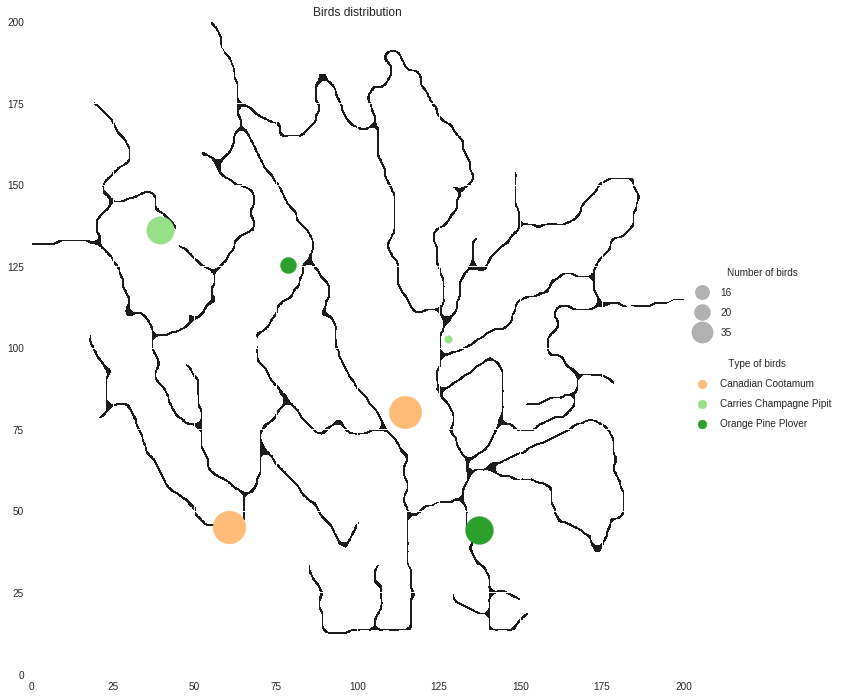

In [49]:
process = color_map( process_cluster( df_useful , 2 ) )
subset_p= process.loc[process['English_name'].isin(['Canadian Cootamum', 'Orange Pine Plover', 'Carries Champagne Pipit']), : ]
plot_map(image_1 , subset_p)

Now splitting each category into five clusters, we get the following: 

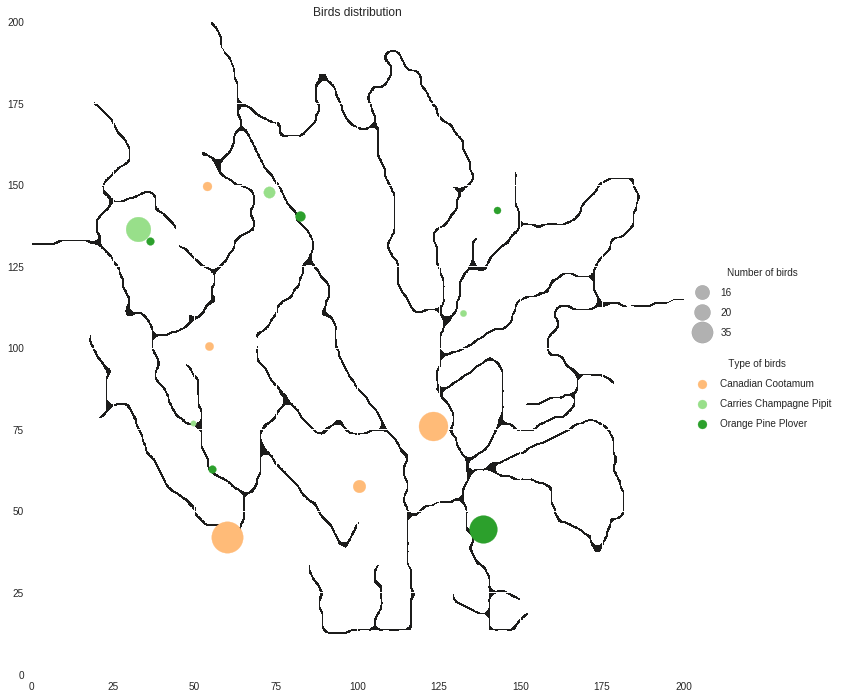

In [51]:
process = color_map( process_cluster( df_useful , 5 ) )
subset_p= process.loc[process['English_name'].isin(['Canadian Cootamum', 'Carries Champagne Pipit', 'Orange Pine Plover']), : ]
plot_map(image_1 , subset_p)

By visualizing the data, we verified an important theorie: birds like to live in groups in restrained areas of the preserve. Only a minority of birds stray from the general localisation and form smaller groups of birds. 

Adding the number of clusters didn't change the main locations for the group regroupments, it only highlighted some lone birds. 

The original habitat of the Blue pipits was located close to the dump zone: if we take a closer look in the case of the blue pipits, we can define the following clusters representing their original locations on the map before the dump happened:

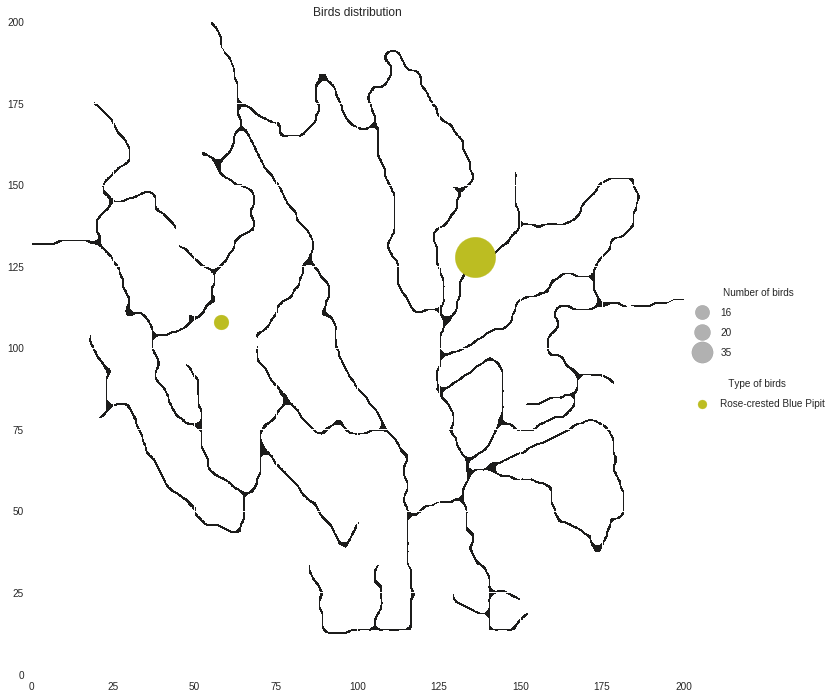

In [52]:
process = color_map( process_cluster( df_useful , 2 ) )
subset_p= process.loc[process['English_name'].isin(['Rose-crested Blue Pipit']), : ]
plot_map(image_1 , subset_p)

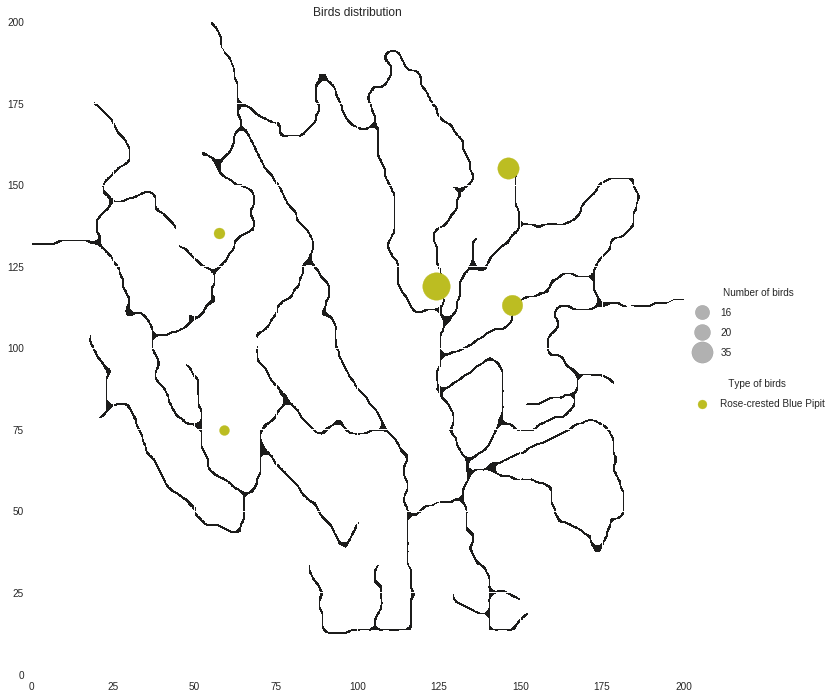

In [53]:
process = color_map( process_cluster( df_useful , 5 ) )
subset_p= process.loc[process['English_name'].isin(['Rose-crested Blue Pipit']), : ]
plot_map(image_1 , subset_p)

Globally, the Blue Pipits seem to be located on the upper right side of the preserve. Now let's display the 15 test locations and check if they seem to belong to one of the clusters:

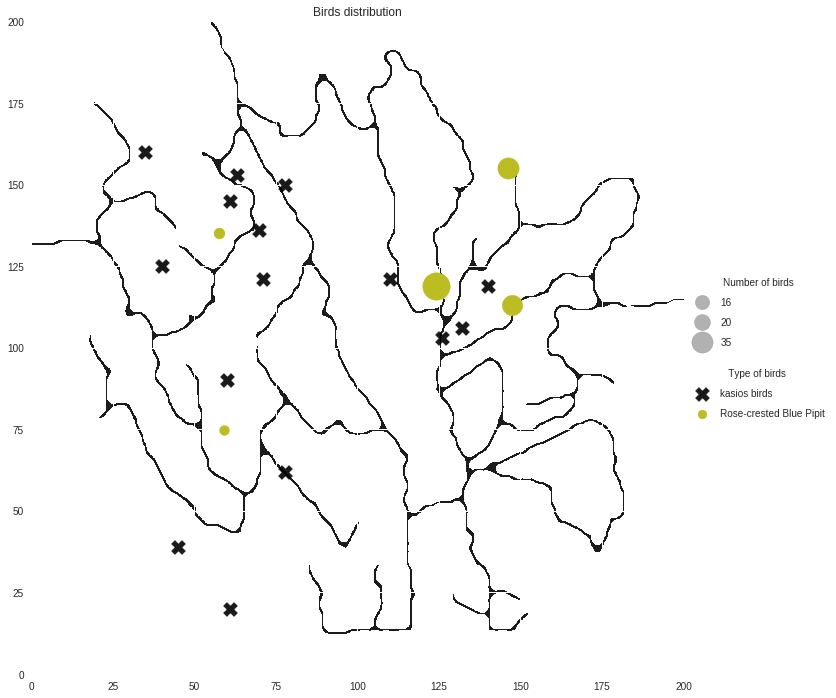

In [54]:
process = color_map( process_cluster( df_useful , 5 ) )
subset_p = process.loc[process['English_name'].isin(['Rose-crested Blue Pipit']), : ]
plot_map_complete(image_1 , subset_p , df_useful_2)

The sample of birds don't seem to display this group caracteristic of birds. if it were the case, the cluster representing the birds is located around this area, which is very far from the blue pipit original cluster. If all thse birds are back and they are indeed blue pipits, why aren't they back to their original spot or close to it ? The data seems to say that very few of the birds seem to be rose crested Blue pipits, and it seems to indicate that we might have different species involved.

This first visual analysis seems to indicate that Kasios are lying to the public. However, before giving our final conclusion, let's try a second approach to decide on whether these birds are blue pipits or not. Let's analyse the mp3 sound files available.

# Part two: Analysing the audio data 

The goal of this second step is to to explore the bird sound files available, and figure out simple visualisations and visual features that would help us classify bird species, or more importantly, distinguish Rose Crested Blue Pipits from other species.

To reach our goal, we will use “ALL BIRDS.zip” that contain calls and songs from the known birds in the Boonsong Lekagul Wildlife Preserve. These files are in MP3 format and are of varying lengths.  


## Different imports:

We start By importing the librairies used in this notebook

In [1]:
import pandas as pd
from pydub import AudioSegment
from os import walk
import matplotlib.pyplot as plt
from scipy.io import wavfile
import subprocess
import os
import scipy as sp
from scipy import signal
import math
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from numpy import cos
from math import pi
import pandas as pd
from pysndfx import AudioEffectsChain
import python_speech_features
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
sns.set()
sns.set_style('whitegrid',{'axes.grid':False})

In [2]:
# to embed figures in the notebook
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

## Step 0 : Basic Preprocessing of our audio format : 

In order to leverage the full power of python librairies when it comes to audio processing and signal decomposition, we will implement a file converter that transforms the audio files from an Mp3 format to Wav, an audio file format widely used with python. 

In [4]:
# # Function used for the for converting mp3 to wav
# def convert_mp3_to_wav(direc,convert=True):
#     f = []
#     dirname=[]
#     for (dirpath, dirnames, filenames) in walk(direc):
#         f.extend(filenames)
#         dirname.extend(dirpath)
#         break
#         if (convert):
#             for i in f:    
#             sound = AudioSegment.from_mp3(direc+i)
#             sound.export(direc+i[:-4]+".wav", format="wav")
#         return f

## Step 1 : Visualize a sound file as a signal 

Let's start by exploring a single wav audio file and visualize a plot of the signal:

In [5]:
train_audio_path ='ALL-BIRDS-WAV/' 
filename = 'Rose-Crested-Blue-Pipit-345802.wav' 

samples,sample_rate = librosa.load(str(train_audio_path) + filename)

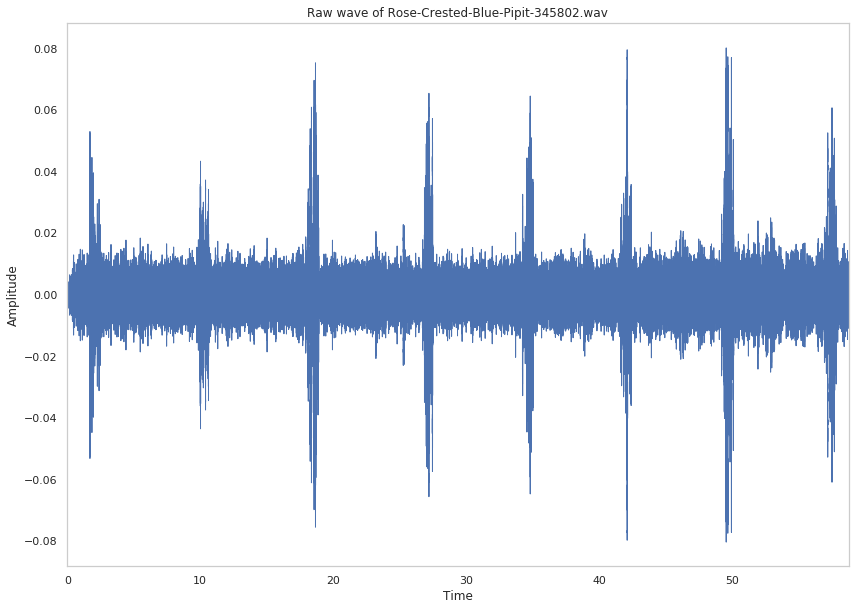

In [6]:
fig = plt.figure(figsize=(14, 10))
plt.title('Raw wave of ' + filename)
plt.ylabel('Amplitude')
librosa.display.waveplot(samples, sample_rate)
plt.show()

One of the first things we notice about our signal is that we have noise that needs to be cleared in a further step for a better quality signal.We will try implementing a denoising module further into our analysis. 

## Step 2 :  Exploring the literature - Important conclusions

Exploring papers and online ressources around classification of bird sounds and decomposition of audio signals, we deduced that the key features to investigate in the next steps are the following:

- Spectral statistics extracted from the FFT-based spectrogram: the most important ones are related to 
the **mean frequency**, the **standard deviation** of the frequencies, and the frequency **mode** . We can also explore other statistics related to the frequencies we leverage from the signal (min, max, quartiles, etc...)

- Time summarisation statistics: Here we rely on time metrics, such as lenghts of the vocalizations or the silences.

In the next step, we will focus on investigating the spectral transformation of our initial signal.

## Step 3 : Visualizing  audio signals and their 2D spectrograms

In this section, we will plot the spectogram of the signal above and see the useful frequency window :

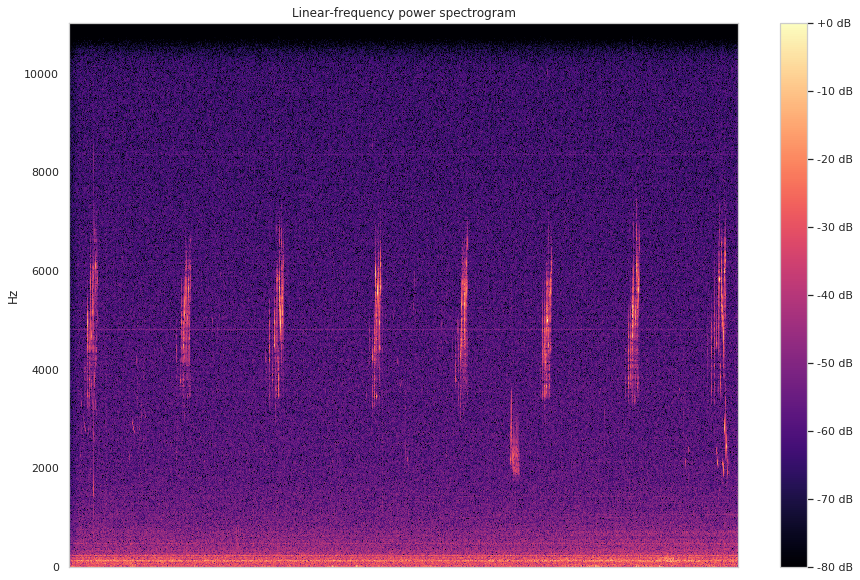

In [7]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(samples)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

Now let's look at the FFT transformation of our signal:

In [8]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = np.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  
    return xf, vals

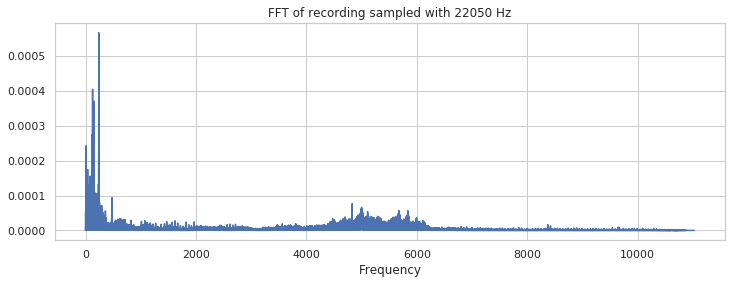

In [9]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

We cleary see here that the "useful" signal are between 4100 Hz and 6100 Hz. The rest is mostly noise we noticed earlier and that we need to remove.

We know that usually, the frequencies of the noise are centred to zero. 

<div class="alert alert-info">

A very usufull information to know about birds : 

* Many bird songs have frequency ranges between 1000 Hz and 8000 Hz, which places them in the sweet spot of human hearing. On the high end, many warblers, sparrows, waxwings, kinglets, and a number of other birds produce sounds that reach 8000 Hz and beyond. 

</div>

*NB*: To improve our approach, we can try to find an automatic way to find the peaks ( the useful signal ). We can use for example find_peaks_cwt, that is similar to findpeaks in matlab.

Let's try now to vizualize the Kasios birds frequency range, and see if it corresponds to the same frequency range as for the bleu pipit.

For this matter, we will choose 3 wav files from the Kasios files, and vizualize them. 

In [85]:
train_audio_path ='Kasios/' 

filename_1 = '1.wav'
filename_2 = '2.wav'
filename_3 = '3.wav'

samples_1,sample_rate_1 = librosa.load(str(train_audio_path) + filename_1)
samples_2,sample_rate_2 = librosa.load(str(train_audio_path) + filename_2)
samples_3,sample_rate_3 = librosa.load(str(train_audio_path) + filename_3)

#### First Kasios file :

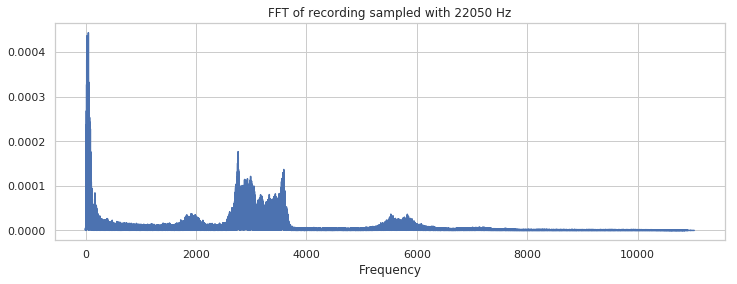

In [86]:
xf, vals = custom_fft(samples_1, sample_rate_1)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate_1) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

For the first example, we clearly see that the useful signal is between 2500Hz and 3500, which is different from the Bleu Pipit case.

#### Second Kasios file :

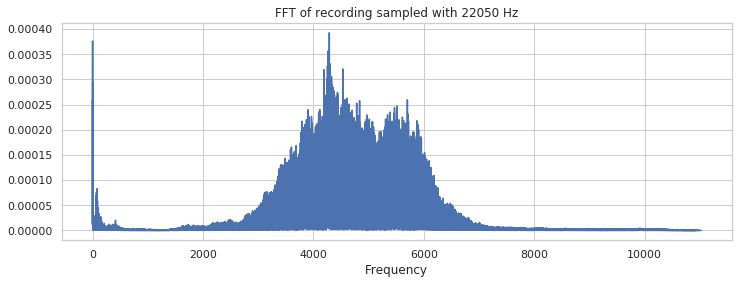

In [87]:
xf, vals = custom_fft(samples_2, sample_rate_2)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate_2) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

Same here, we clearly see that the frequency range is huge comparing of what it should have been for a blue pipit. 

#### Third Kasios file :

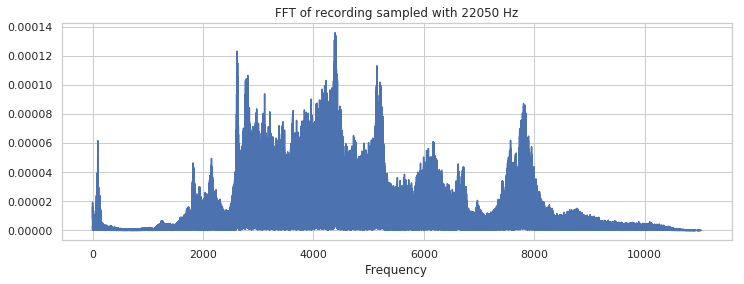

In [88]:
xf, vals = custom_fft(samples_3, sample_rate_3)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate_3) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

Same case here, we see that the frequency range of this signal is way bigger than what it is supposed to be. 
We clearly see also, that even for these 3 files we just vizualized, we do not get the same shape of signals, which means that Kasios might be wrong about the type of birds they have recorded.

On the next steps, we will try to denoise the signals, and try to extract features from every signal, to see wether our hypothesis about Kasios being wrong is true or not. 

----------------------------------------------------------------------------

## Denoising the signal

Before moving forward with our analysis, let's implement a band-pass filter to try to reduce the background noise :

References : https://github.com/scipy/scipy/issues/8485

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

No handles with labels found to put in legend.


<Figure size 1080x720 with 0 Axes>

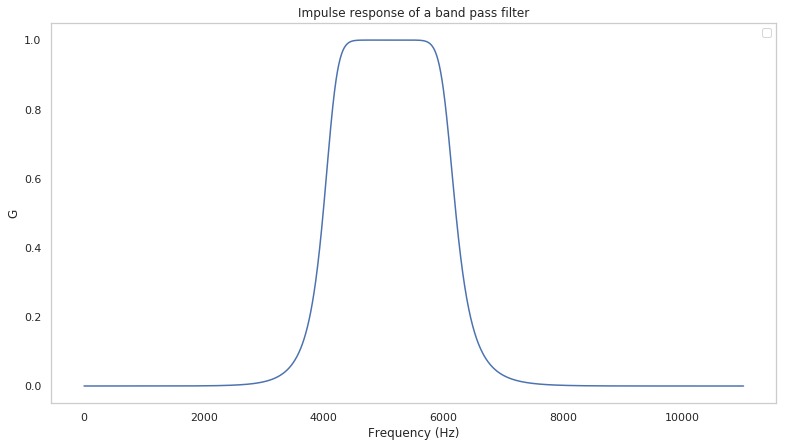

In [11]:
#That we got above from the librosa function
fs = sample_rate

lowcut = 4100 
highcut = 6100 
#These values that Ive got manually from just vizulazing the spectogram. 


# Plot the frequency response. 
plt.figure(1)
plt.clf()
b, a = butter_bandpass(lowcut, highcut, fs)
w, h = freqz(b, a, worN=2000)

plt.figure(figsize=(13, 7))
plt.plot((fs * 0.5 / np.pi) * w, abs(h))
plt.xlabel('Frequency (Hz)')
plt.ylabel('G')
plt.title('Impulse response of a band pass filter')
plt.legend(loc='best')
plt.show()

The selected frequencies are in the range defined earlier. 

The new signal we've got : 

No handles with labels found to put in legend.


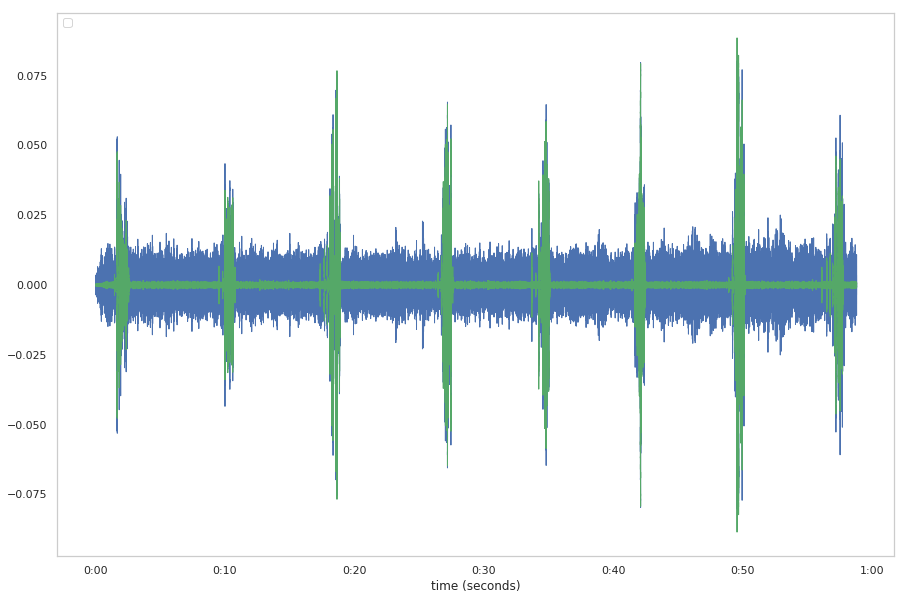

In [12]:
### superimpose waveplots for filtred and real signal 
filtered_signal = butter_bandpass_filter(samples, lowcut, highcut, fs, order=5)
librosa.display.waveplot(samples,fs)
librosa.display.waveplot(filtered_signal,fs,color='g')


plt.xlabel('time (seconds)')
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

The new spectogram we've got :

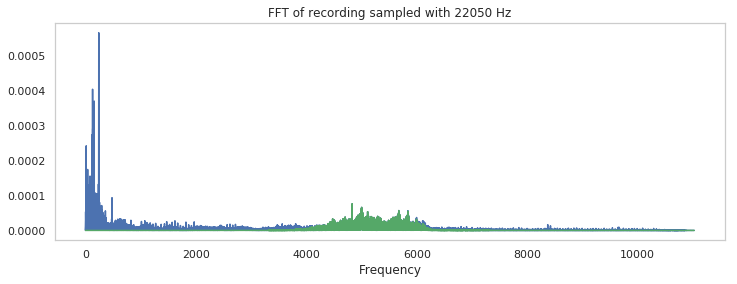

In [13]:
xf, vals = custom_fft(filtered_signal, sample_rate)
xf_old, vals_old = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf_old, vals_old)
plt.plot(xf, vals, color='g')
plt.xlabel('Frequency')
plt.show()

We see that we have removed the background noise keeping only the green signal which is more representative of the bird's real vocals. The spectrogram also displays the importants frequencies behind the birds vocalisation phases.

## First conclusions 

We notice that in this case, the blue pipit audio has the following charasteristics: 
- short intervals of equivalent lenghts with vocalisation of the bird with a similar magnitude repeated at a steady interval
- Long pauses in between represented by a flat line where the background noise used to be: the bird is silent for a while before resuming its activity and the noise was probably generated by the background. 

This pattern is present on several blue pipit recordings and can be a useful way to distinguish blue pipits from other birds using a simple visual transformation of our signal. 

We have also defined a fast method to denoise our signal based on using filters to reduce the noise. Now we can investigate further how we can extract useful feature to distinguish our blue pipits from other birds.

#### We will here try the same procedure, with an other type of birds :

We will try this with an other example of birds : The Blue-collared-Zipper. 

In [14]:
filename = 'Blue-collared-Zipper-251570.wav' 

samples,sample_rate = librosa.load(str(train_audio_path) + filename)

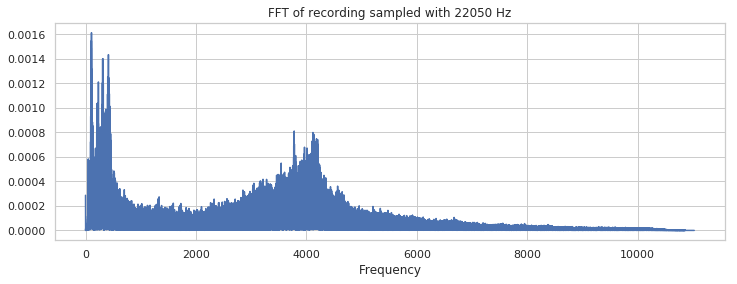

In [15]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

In this case, the useful signal is between 2800Hz and 5000 Hz. 

No handles with labels found to put in legend.


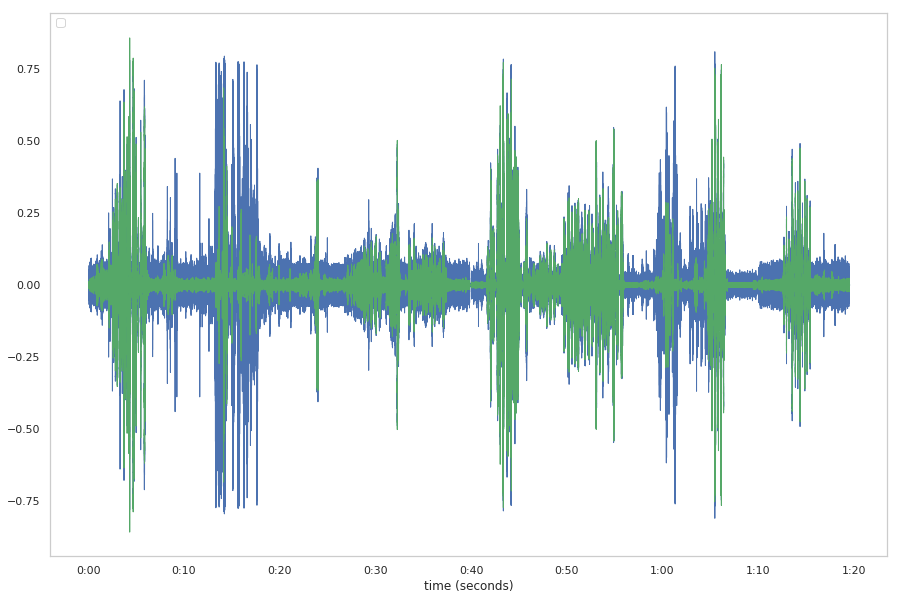

In [16]:
#That we got above from the librosa function
fs = sample_rate

lowcut = 2800
highcut = 5000 
#That we got manually from the vizualization. 

filtered_signal = butter_bandpass_filter(samples, lowcut, highcut, fs, order=5)
librosa.display.waveplot(samples,fs)
librosa.display.waveplot(filtered_signal,fs,color='g')


plt.xlabel('time (seconds)')
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

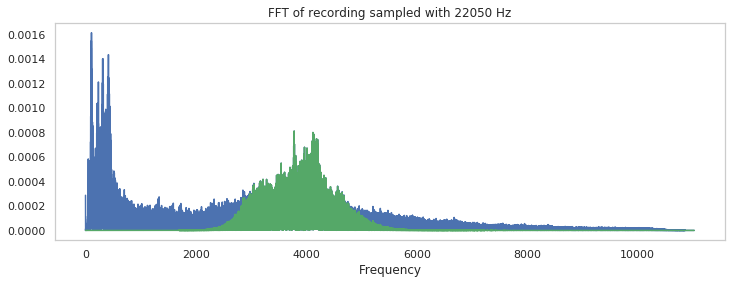

In [17]:
xf, vals = custom_fft(filtered_signal, sample_rate)
xf_old, vals_old = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf_old, vals_old)
plt.plot(xf, vals, color='g')
plt.xlabel('Frequency')
plt.show()

## Second conclusions 

We clearly see that both birds have different sound frequency ranges that best represent their vocalisations. This way, we are able to distinguish the true voice frequency range of blue pipits versus other species.

In this part, we attempted using the useful frequency ranges as well as the signal's shape and magnitude as simple indicators of the birds species. Looking at the FFT representation and the signal plots have given us indicators on how to use time and frequency statistics to classify birds. 

Now let's try to use a more complex approach. 

## Automatic denoising :

In [18]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

In [19]:
train_audio_path ='ALL-BIRDS-WAV/' 
filename = 'Rose-Crested-Blue-Pipit-345802.wav' 

signal,sample_rate = librosa.load(str(train_audio_path) + filename)

### The use of a pre emphasis filter :

For the first step, we will apply a pre-emphasis filter on the signal to amplify the high frequencies. 

A pre-emphasis filter is useful in several ways: 
- balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, 
- avoid numerical problems during the Fourier transform operation and 
- may also improve the Signal-to-Noise Ratio (SNR).

In [20]:
def pre_emphasis_filter(signal):
    #We have now: 
    # y(t) = x(t) - α.x(t-1)
    #typical values for the filter coefficient (α) are 0.95 or 0.97
    pre_emphasis = 0.97
    return numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [21]:
def plot_signal(samples, text):
    fig = plt.figure(figsize=(14, 10))
    plt.title(text)
    plt.ylabel('Amplitude')
    librosa.display.waveplot(samples, sample_rate)
    plt.show()

In [22]:
emphasized_signal = pre_emphasis_filter(signal)

We will now plot both signals, before and after the pre-emphasis filter.

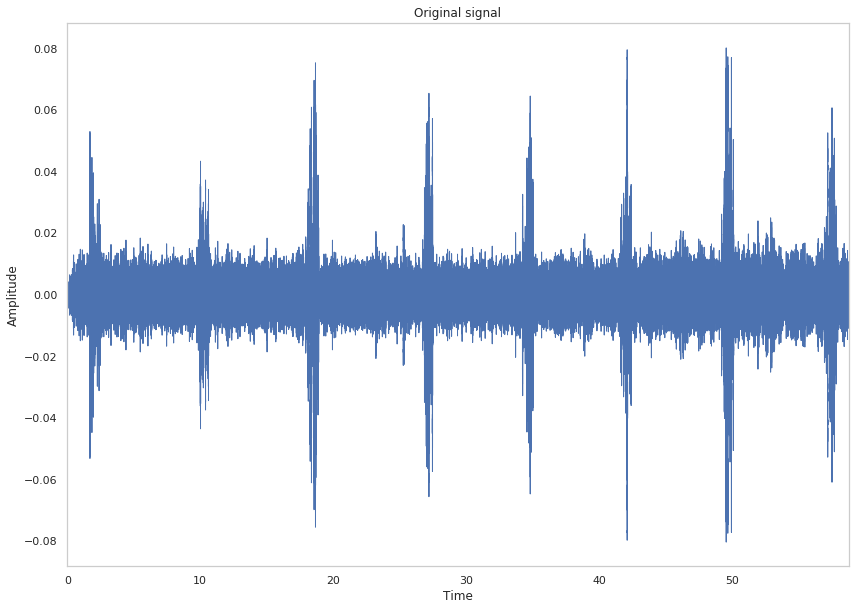

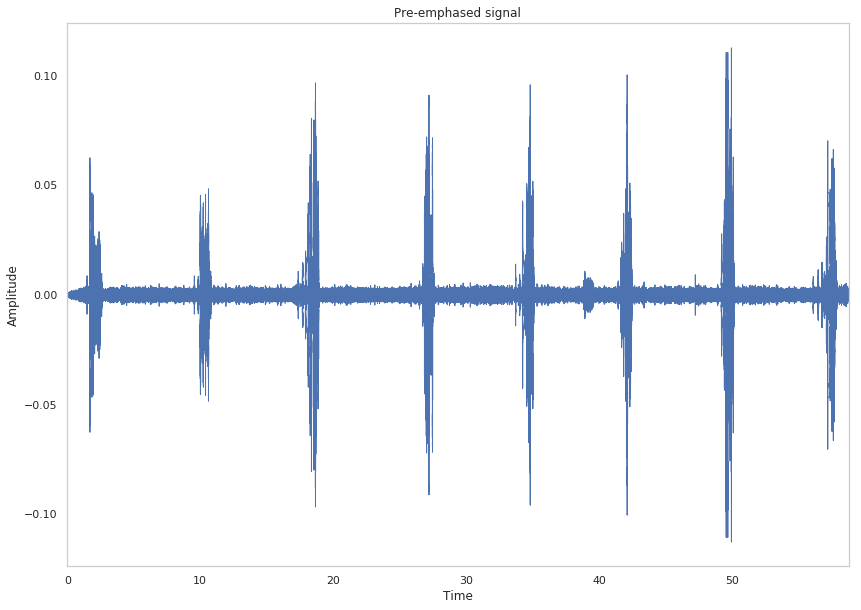

In [23]:
plot_signal(signal,'Original signal')
plot_signal(emphasized_signal,'Pre-emphased signal')

We clearly see now that the noise got reduced. We do not have to plot anymore the signal, to check the frequencies range where the relevant signal. 

A pre-emphasis filter is very useful for the next steps, to reduce the noise, and to, extract the right signal features.

------------------------------------------------------------------------------------------------------------

# Features extraction : Finding visual features 

### MFCC : Mel-frequency cepstral coefficients

Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition. They were introduced by Davis and Mermelstein in the 1980's, and have been state-of-the-art ever since. 

The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope.

We will try to define our signal's MFCC, which can be viewed as the signal's DNA representation. We hope to find correlated MFCCs for blue pipits that we can compare later to the Kasios audio files and come up with a conclusion on whether the blue pipits are back or not.

In [24]:
def finding_name_files(dictionnaire,name):
    lower_cast_name=name.lower()
    res=[name for name, low_name in dictionnaire.items() if low_name == lower_cast_name]
    return res[0]

In [25]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

In [26]:
def extract_features(parent_dir,file_ext=".wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []

    pos={}
    nb=0
    nb_prev=0
    k=0
    
    for count in range(name_file.shape[0]):
        
        fn = os.path.join(parent_dir,finding_name_files(dictionnaire,name_file[count]+file_ext))
        
        # Load audio clip into librosa
        sound_clip,s = librosa.load(fn)
        
        # Normalize audio
        sound_clip_normalized = librosa.util.normalize(sound_clip)
        
        #-------------------------------------------------
        #-------------------------------------------------
        #DENOISING THE SIGNAL IS HERE
        #-------------------------------------------------
        #-------------------------------------------------
        
        # Split audio time series into non-silent sections
        split_array = librosa.effects.split(sound_clip_normalized, top_db=10, frame_length=32768, hop_length=256)
        split_chirps = []
        
        # Reform a single time series from the separate non-silent components
        for i,interval in enumerate(split_array):
            split_chirps.append(librosa.effects.remix(sound_clip_normalized, intervals=[interval]))
        
        # Loop through each individual audio segment (bird chirp) and apply MFCC to generate features
        k=0
        for i, audio_segment in enumerate(split_chirps):

            for (start,end) in windows(audio_segment,window_size):
                start = int(start)
                end = int(end)
                if(len(audio_segment[start:end]) == window_size):
                    signal = audio_segment[start:end]
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    k=k+1
        
        #Useful for the signal positions
        nb_prev=nb
        nb=nb+k        
        pos[finding_name_files(dictionnaire,name_file[count]+file_ext)]=(nb_prev,nb)

    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features), pos

In [27]:
#Different initializations: 
parent_dir = 'ALL-BIRDS-WAV/'
sample_DF=pd.read_csv('AllBirdsv4.csv')

#---------------------------------------------------

#Getting the file names :
name_file=sample_DF['English_name']+'-'+sample_DF['File ID'].apply(str)
name_file=name_file.replace(' ', '-',regex=True)
name_file=name_file[:10]

#---------------------------------------------------

dictionnaire={}
wav_files = []

for root, dirs, files in os.walk("ALL-BIRDS-WAV/"):  
    for filename in files:
        wav_files.append(filename)
        
for file in wav_files:
    dictionnaire[file]=str(file).lower()

#---------------------------------------------------
    
features, position = extract_features(parent_dir)

Some representations of the signal features :

In [28]:
#Useful function for the features plots :
def ix(dic, n): 
    return list(dic)[n]

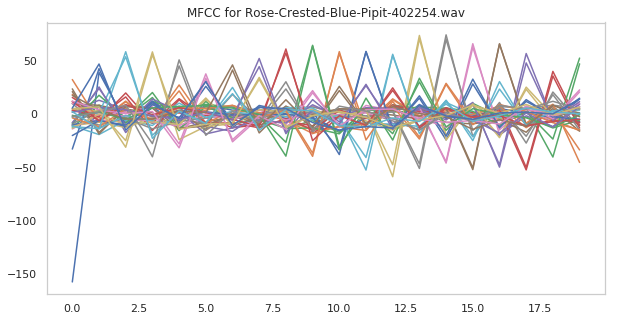

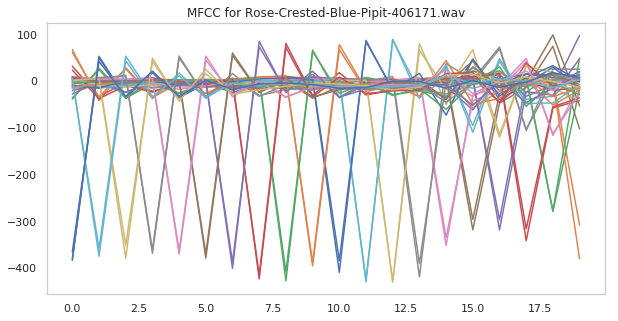

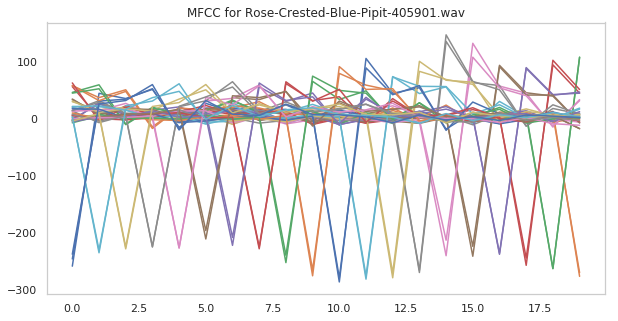

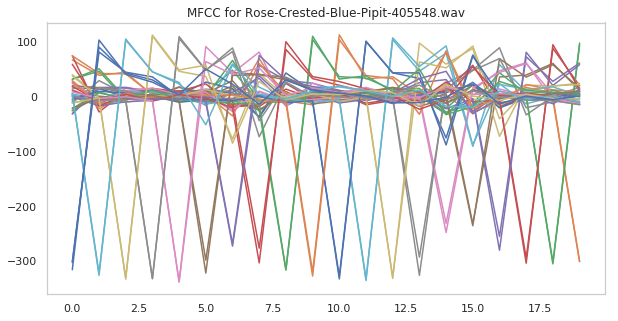

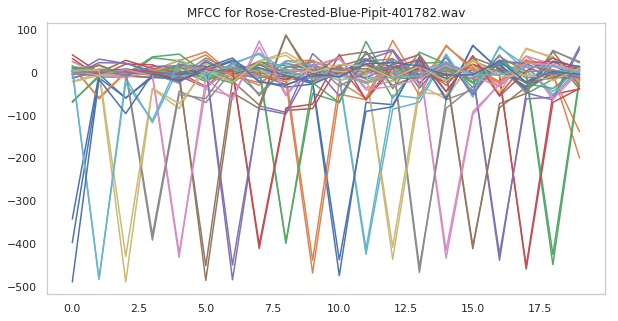

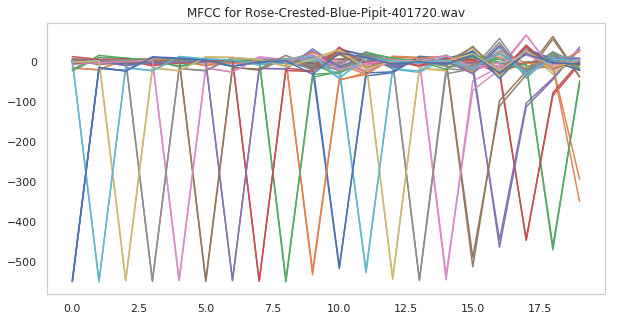

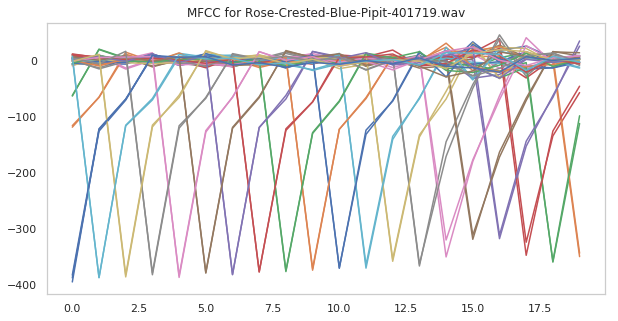

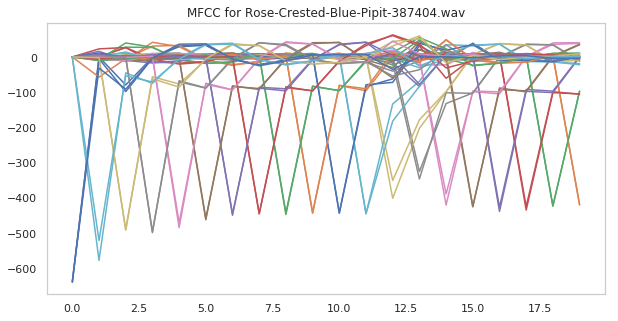

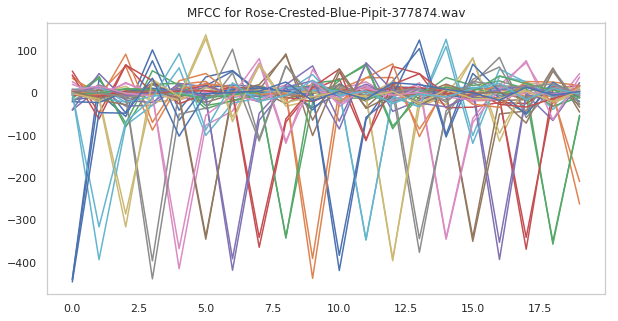

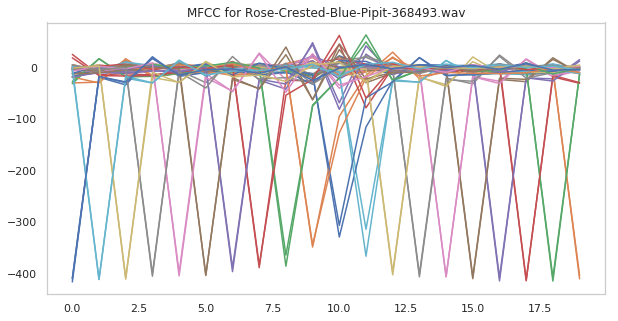

In [29]:
for i in range(len(position)):
    plt.figure(figsize=(10,5))
    plt.plot(features[position[ix(position,i)][0]])
    plt.title('MFCC for '+ix(position,i))
    plt.show()

Let's look at the other bird category: 

In [30]:
name_file=np.array(['Blue-collared-Zipper-257777'])

In [31]:
features, position = extract_features(parent_dir)

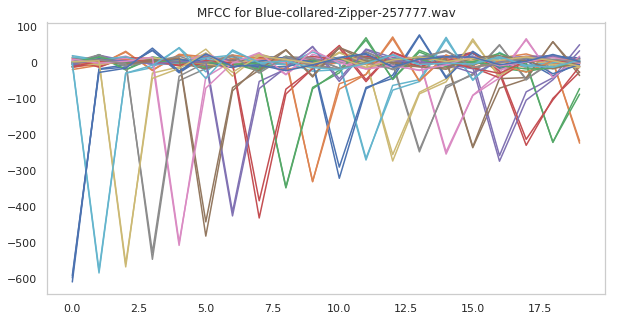

In [32]:
for i in range(len(position)):
    plt.figure(figsize=(10,5))
    plt.plot(features[position[ix(position,i)][0]])
    plt.title('MFCC for '+ix(position,i))
    plt.show()

Conclusion : We see a different between the figure that corresponds for the Blue Collared Zipper, and between the 10 previous plots that correspond to the Blue Pipit. The shape of the MFCC seems to be an additionnal indicator on whether or not we are dealing with Blue Pipits.

References : https://github.com/chadstolper/vast-challenge-2018-mc1/blob/master/Bird_Classification.ipynb

-----------------------------------------------------------------------------------------------------

In order to use the MFCC, we need very high computational power. 
During the following part of the project, we will try to compute some other features and use the decision tree model to get the results. 

-----------------------------------------------------------------------------------------------------

# Part 3 : Classifying the bird calls

## Some preprocessing : 

We will try to compute a dataframe with the name of the different species.

In [33]:
direct=  'ALL-BIRDS-WAV/'
df= pd.DataFrame(os.listdir(direct), columns= ['path'])
df['specie']= df['path'].apply(lambda x : '-'.join(x.split('.')[0].split('-')[:-1]) )

In [34]:
df.head()

path                specie
0           Queenscoat-345890.wav            Queenscoat
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover
2             Bombadil-180230.wav              Bombadil
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper

In [35]:
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 2 columns):
path      2081 non-null object
specie    2081 non-null object
dtypes: object(2)
memory usage: 32.6+ KB


The problem here is that the dataframe is too big to process for our type of computers, this is why, we will just keep 5 records per specie. 

In [36]:
df_sub= df.groupby('specie').head(5).reset_index(drop= True)
df_sub.head()

path                specie
0           Queenscoat-345890.wav            Queenscoat
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover
2             Bombadil-180230.wav              Bombadil
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper

In [37]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
path      95 non-null object
specie    95 non-null object
dtypes: object(2)
memory usage: 1.6+ KB


We will now define a function to read the different sound files in order to process them. 

In [38]:
def read_audio(path):
    """ This function takes a recording and returns an array containing the samples, and a sample rate."""
    
    samples, sample_rate= librosa.load(direct + path)
    return samples, sample_rate

In [39]:
df_sub['signal'] = df_sub['path'].apply(lambda x : read_audio(x))

In [40]:
df_sub.head(5)

path                specie  \
0           Queenscoat-345890.wav            Queenscoat   
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover   
2             Bombadil-180230.wav              Bombadil   
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout   
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper   

                                              signal  
0  ([8.249774e-06, -1.7660212e-05, 4.013914e-06, ...  
1  ([-1.1953728e-07, 1.354935e-07, -1.4934027e-07...  
2  ([-8.519121e-08, 8.425059e-08, -7.918575e-08, ...  
3  ([-8.519121e-08, 8.425059e-08, -7.918575e-08, ...  
4  ([-1.7038242e-07, 1.6850117e-07, -1.583715e-07...

### Denoising the signal:

In [41]:
df_sub['denoised_signal'] = df_sub['signal'].apply(lambda x : pre_emphasis_filter(x[0]))

In [42]:
df_sub['signal'] = df_sub['signal'].apply(lambda x : list(x))

In [43]:
for i in range(len(df_sub)):
    df_sub['signal'][i][0] = (df_sub['denoised_signal'][i]).copy()

In [44]:
del df_sub['denoised_signal']

Now, we will start defining some signal features that will be so useful.

### 1- Zero-crossing rate (Zcr) :

The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

In [45]:
def zcr(frame):
    """This fonction takes a path and computes zero crossing rate of frame"""
    
    count = len(frame)
    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return (np.float64(countZ) / np.float64(count-1.0))

In [46]:
df_sub['ZCR'] = df_sub['signal'].apply(lambda x : zcr(frame = x[0]))

In [47]:
df_sub.head(5)

path                specie  \
0           Queenscoat-345890.wav            Queenscoat   
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover   
2             Bombadil-180230.wav              Bombadil   
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout   
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper   

                                              signal       ZCR  
0  [[8.249774e-06, -2.5662492e-05, 2.1144318e-05,...  0.400262  
1  [[-1.1953728e-07, 2.5144465e-07, -2.8076897e-0...  0.384542  
2  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.264745  
3  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.448003  
4  [[-1.7038242e-07, 3.337721e-07, -3.2181765e-07...  0.528363

We clearly see that the ZCR feature has been added to our dataframe. 

### 2- Signal energy :

In [48]:
def stEnergy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))

In [49]:
df_sub['energy'] = df_sub['signal'].apply(lambda x : stEnergy(x[0]))

In [50]:
df_sub.head(5)

path                specie  \
0           Queenscoat-345890.wav            Queenscoat   
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover   
2             Bombadil-180230.wav              Bombadil   
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout   
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper   

                                              signal       ZCR    energy  
0  [[8.249774e-06, -2.5662492e-05, 2.1144318e-05,...  0.400262  0.003001  
1  [[-1.1953728e-07, 2.5144465e-07, -2.8076897e-0...  0.384542  0.000534  
2  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.264745  0.000021  
3  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.448003  0.002034  
4  [[-1.7038242e-07, 3.337721e-07, -3.2181765e-07...  0.528363  0.008504

### 3- Signal entropy :

In [51]:
def stEnergyEntropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    eps = 0.000000001
    Eol = np.sum(frame ** 2)    # total frame energy
    L = len(frame)
    sub_win_len = int(np.floor(L / n_short_blocks))
    if L != sub_win_len * n_short_blocks:
            frame = frame[0:sub_win_len * n_short_blocks]
    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -np.sum(s * np.log2(s + eps))
    return Entropy

In [52]:
df_sub['stEnergyEntropy'] = df_sub['signal'].apply(lambda x : stEnergyEntropy(x[0]))

In [53]:
df_sub.head(5)

path                specie  \
0           Queenscoat-345890.wav            Queenscoat   
1    Orange-Pine-Plover-70949.wav    Orange-Pine-Plover   
2             Bombadil-180230.wav              Bombadil   
3   Purple-Tooting-Tout-73055.wav   Purple-Tooting-Tout   
4  Blue-collared-Zipper-52081.wav  Blue-collared-Zipper   

                                              signal       ZCR    energy  \
0  [[8.249774e-06, -2.5662492e-05, 2.1144318e-05,...  0.400262  0.003001   
1  [[-1.1953728e-07, 2.5144465e-07, -2.8076897e-0...  0.384542  0.000534   
2  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.264745  0.000021   
3  [[-8.519121e-08, 1.6688605e-07, -1.6090883e-07...  0.448003  0.002034   
4  [[-1.7038242e-07, 3.337721e-07, -3.2181765e-07...  0.528363  0.008504   

   stEnergyEntropy  
0         1.662062  
1         2.674368  
2         2.725145  
3         2.495940  
4         2.771259

### 4- Spectral centroid :

In [54]:
def spectral_centroid(x, samplerate):
    """Computes spectral centroid of frame (given abs(FFT))"""
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies  
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

In [55]:
df_sub['spectral_centroid'] = df_sub['signal'].apply(lambda x : spectral_centroid(*x))

We have computed 4 different features, and we will now try to generate the model.

### The model - Decision Tree :

Different imports needed to generate the model :

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

We will now compute the label column to our dataframe. Since we want to know, if the bird is wether a Rose Crested Blue pipit or not. We will assign 1 if it is the case, 0 if it's not. 

In [57]:
y =(df_sub['specie']=='Rose-Crested-Blue-Pipit')

We take a look at our dataframe, to see if there are any changes that needs to be made. 

In [58]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
path                 95 non-null object
specie               95 non-null object
signal               95 non-null object
ZCR                  95 non-null float64
energy               95 non-null float64
stEnergyEntropy      95 non-null float64
spectral_centroid    95 non-null float64
dtypes: float64(4), object(3)
memory usage: 5.3+ KB


In [59]:
del df_sub['specie']
del df_subb['signal']
del df_sub['path']

These columns wont be needed for the prediction. 

We will now try to split our data, to train our model, then compute it's accuracy. 

In [61]:
x_train , x_test, y_train, y_test = train_test_split(df_sub, y, test_size = 0.25, random_state = 0)

We take a look at our X_train matrix to vizualize the different features that we used. 

In [63]:
x_train.head(5)

ZCR    energy  stEnergyEntropy  spectral_centroid
42  0.374786  0.000614         1.509134        5414.830325
48  0.377188  0.002334         2.735918        4915.554687
74  0.604248  0.000813         3.237484        6299.739121
88  0.443380  0.004918         1.751992        4322.012952
78  0.316757  0.000056         3.260097        3344.580965

Now, the only thing left to do, is to run our model :

In [64]:
classifier = DecisionTreeClassifier(criterion = 'entropy')
classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

After running our model, we will try to compute the accuracy of our model, based on the test data we had. 

In [65]:
y_pred = classifier.predict(x_test)

In [66]:
cm = confusion_matrix(y_test, y_pred)
accuracy = sum(cm[i][i] for i in range(2)) / y_test.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.875


Now we will display our confusion matrix.

In [67]:
cm

array([[21,  3],
       [ 0,  0]])

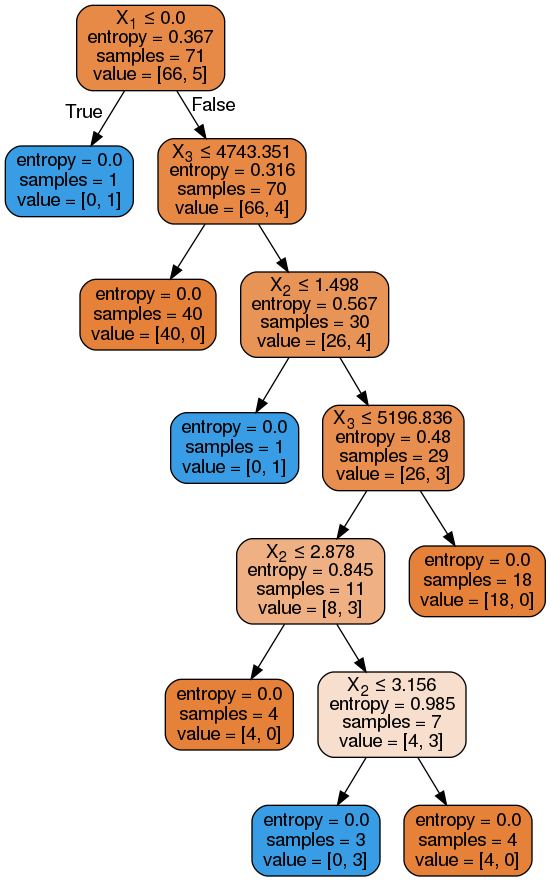

In [68]:
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

-----------------------------------------------------------------------------------------------------

### Classifying Kasios birds :

Now, we will try to see if the hypothesis made by Kasios, that the different birds that they have heard are trully Rose Crested Blue pipit or not. 

In [69]:
df_test=pd.DataFrame()
path= ['/../Kasios/' + str(i)+ '.wav' for i in range (1, 16)]
df_test['path']=path

Reading the different Kasios audio files :

In [70]:
df_test['signal'] = df_test['path'].apply(lambda x : read_audio(x))
df_test['denoised_signal'] = df_test['signal'].apply(lambda x : pre_emphasis_filter(x[0]))
df_test['signal'] = df_test['signal'].apply(lambda x : list(x))

for i in range(len(df_test)):
    df_test['signal'][i][0] = (df_test['denoised_signal'][i]).copy()
    
del df_test['denoised_signal']

Computing the different features for the Kasios audio files :

In [73]:
df_test['ZCR'] = df_test['signal'].apply(lambda x : zcr(frame = x[0]))
df_test['energy'] = df_test['signal'].apply(lambda x : stEnergy(x[0]))
df_test['stEnergyEntropy'] = df_test['signal'].apply(lambda x : stEnergyEntropy(x[0]))
df_test['spectral_centroid'] = df_test['signal'].apply(lambda x : spectral_centroid(*x))

We take a look at our test data frame before the prediction :

In [74]:
df_test.head(5)

path                                             signal  \
0  /../Kasios/1.wav  [[2.8909324e-06, 1.7920252e-07, -3.7346158e-06...   
1  /../Kasios/2.wav  [[-3.605862e-07, 7.6939784e-07, -1.0402653e-06...   
2  /../Kasios/3.wav  [[9.726473e-06, -3.3788256e-06, -9.469016e-06,...   
3  /../Kasios/4.wav  [[2.1343914e-05, -1.6407459e-05, 8.3588175e-06...   
4  /../Kasios/5.wav  [[-0.0003385125, 0.0008409263, 0.00045613985, ...   

        ZCR    energy  stEnergyEntropy  spectral_centroid  
0  0.484260  0.000059         2.913527        4130.743279  
1  0.397149  0.000834         3.245953        4989.256215  
2  0.376749  0.000208         2.478992        5538.184691  
3  0.362329  0.000435         1.828274        4885.842826  
4  0.412301  0.000183         2.313978        2806.838636

We do the same as before, and we remove the column that we do not need anymore. 

In [75]:
del df_test['path']
del df_test['signal']

Now, we predict wether the birds are Rose Crested Bleu Pipit or not :

In [76]:
y_pred = classifier.predict(df_test)

Displaying the results : 

In [77]:
y_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

Accuracy : 

In [78]:
acc = 0
for i in range((len(y_pred))):
    if y_pred[i]:
        acc += 1
        
print('Kasios were right about ', acc/len(y_pred),'% of tested birds.')       

Kasios were right about  0.0 % of tested birds.


# Conclusion

In light of our investigation of the data provided to us, we deem that Kasios claim that the Rose Crested Blue Pipits are back to the preserve unharmed are false. The samples provided have little to no chance to belong to the Blue pipit's species and thus can't be used to back up their claim. 